Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [32]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.regularizers import l2

In [2]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [61]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Upgrad/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/Upgrad/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/')

In [62]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [18]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [26]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
    pad_to_aspect_ratio=False,
    data_format=None,
    verbose=True
)

Found 2239 files belonging to 9 classes.


In [27]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_test,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
    pad_to_aspect_ratio=False,
    data_format=None,
    verbose=True
)

Found 118 files belonging to 9 classes.


In [28]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

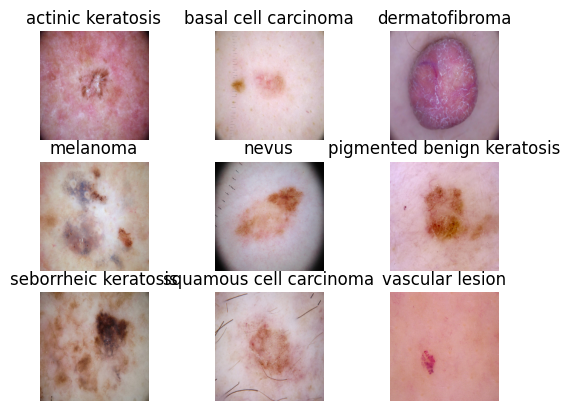

In [22]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
for i in range(len(class_names)):
    filtered_ds = train_ds.filter(lambda x, l: tf.math.equal(l[0], i))
    for image, label in filtered_ds.take(1):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(image[0].numpy().astype('uint8'))
        plt.title(class_names[label.numpy()[0]])
        plt.axis('off')

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [23]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [24]:
#normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
#normalized_training_set = train_ds.map(lambda x, y: (normalization_layer(x), y))
#training_image_batch,training_labels_batch = next(iter(normalized_training_set))

resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(img_height, img_width),
    layers.Rescaling(1./255),
])

In [29]:
class_names = train_ds.class_names
num_classes = len(class_names)
num_classes

9

In [30]:
for batch in train_ds.take(1):
    #print(batch)
    input_shape = batch[0].shape
    print(input_shape)
    print(input_shape[1:])

(32, 180, 180, 3)
(180, 180, 3)


In [33]:
### Your code goes here
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=input_shape[1:]))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512,kernel_regularizer=l2(0.01)))
model.add(Activation('relu'))
#model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Compile the model
Choose an appropirate optimiser and loss function for model training

In [34]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='sgd',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [35]:
# View the summary of all layers
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 180, 180, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 180, 180, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 178, 178, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 178, 178, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 178, 178, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 89, 89, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 89, 89, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 89, 89, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 87, 87, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 87, 87, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 87, 87, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 118336)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      60,588,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           4,617 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 9)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 60,659,497 (231.40 MB)

 Trainable params: 60,659,113 (231.40 MB)

 Non-trainable params: 384 (1.50 KB)

### Train the model

In [36]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 402s 6s/step - accuracy: 0.3143 - loss: 13.7725 - val_accuracy: 0.1356 - val_loss: 14.9141
Epoch 2/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 23s 330ms/step - accuracy: 0.5070 - loss: 11.2379 - val_accuracy: 0.1356 - val_loss: 15.5172
Epoch 3/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 40s 319ms/step - accuracy: 0.6067 - loss: 10.6790 - val_accuracy: 0.2203 - val_loss: 12.4308
Epoch 4/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 42s 340ms/step - accuracy: 0.7123 - loss: 10.1847 - val_accuracy: 0.2373 - val_loss: 14.1922
Epoch 5/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 41s 349ms/step - accuracy: 0.7397 - loss: 9.7797 - val_accuracy: 0.2966 - val_loss: 11.8596
Epoch 6/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 23s 330ms/step - accuracy: 0.8245 - loss: 9.3367 - val_accuracy: 0.3559 - val_loss: 11.3377
Epoch 7/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 42s 346ms/step - accuracy: 0.8745 - loss: 8.9523 - val_accuracy: 0.3136 - val_loss: 10.9112
Epoch 8/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 39s 326ms/step - accuracy: 0.8811 - loss: 8.6754 -

### Visualizing training results

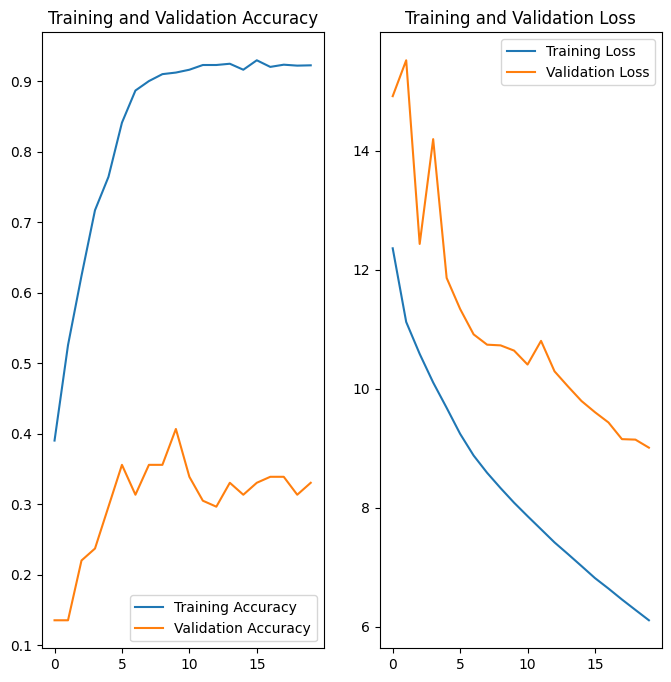

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

In [ ]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
# Your code goes here

# Findings are mentioned below in the text format


#### **Findings:**
----------
**- Model is overfitting after running for 2 Epochs.**

*   **Model is overfitting after running for 2 Epochs.**
*   **Training Accuracy is 0.9169 which indicates overfitting**
*   **Validation Accuracy is 0.3305 which does not improve after each epochs**
*   **We can add dropout layers and augmentation strategy for reducing the overfitting problem.**


In [ ]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

### Todo:
### Create the model, compile and train the model


In [38]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=input_shape[1:]))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512,kernel_regularizer=l2(0.01)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Compiling the model

In [39]:
## Your code goes here
model.compile(optimizer='sgd',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### Training the model

In [40]:
## Your code goes here, note: train your model for 20 epochs
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 34s 400ms/step - accuracy: 0.2516 - loss: 23.7215 - val_accuracy: 0.1356 - val_loss: 58.4526
Epoch 2/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 33s 358ms/step - accuracy: 0.4023 - loss: 11.8854 - val_accuracy: 0.1780 - val_loss: 13.7793
Epoch 3/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 41s 362ms/step - accuracy: 0.4383 - loss: 11.4232 - val_accuracy: 0.2542 - val_loss: 13.0721
Epoch 4/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 41s 367ms/step - accuracy: 0.4924 - loss: 11.0071 - val_accuracy: 0.2966 - val_loss: 11.8313
Epoch 5/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 42s 387ms/step - accuracy: 0.5188 - loss: 10.6627 - val_accuracy: 0.2458 - val_loss: 11.6487
Epoch 6/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 41s 385ms/step - accuracy: 0.5276 - loss: 10.3465 - val_accuracy: 0.3136 - val_loss: 11.8308
Epoch 7/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 40s 366ms/step - accuracy: 0.5516 - loss: 10.0475 - val_accuracy: 0.3475 - val_loss: 11.4081
Epoch 8/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 25s 353ms/step - accuracy: 0.5919 - loss: 9.7

### Visualizing the results

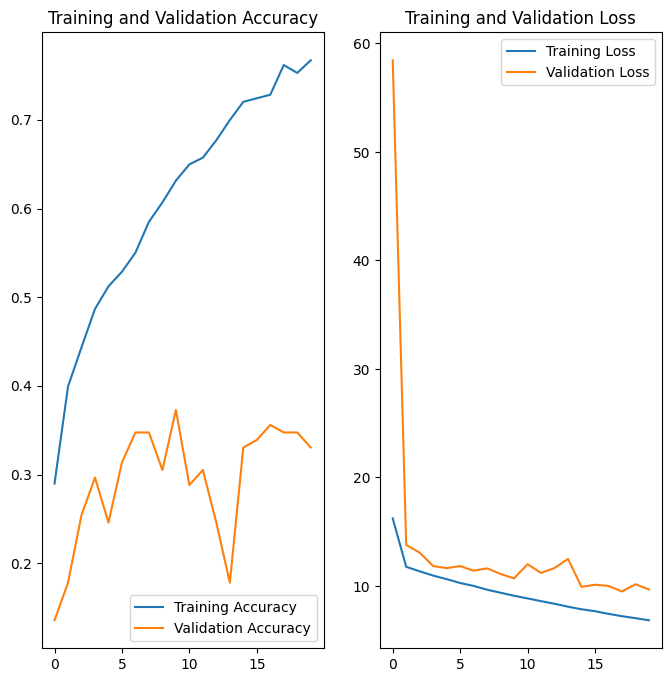

In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

Findings:
-----------
Model Performance has improved slightly after adding the dropout layer.
Now the training accuracy is 0.7579 reduced from previous run
Validation accuracy is 0.3305
Still there is a scope for improvement

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [47]:
## Your code goes here.
#for i in range(len(class_names)):
#    filtered_ds = train_ds.filter(lambda x, l: tf.math.equal(l[0], i))
#    print("class_names[i]: ", class_names[i])
#    print("No of samples: ", filtered_ds.)
    #for image, label in filtered_ds.take(1):
     #   ax = plt.subplot(3, 3, i+1)
      #  plt.imshow(image[0].numpy().astype('uint8'))
       # plt.title(class_names[label.numpy()[0]])
        #plt.axis('off')

import pandas as pd
dataset_unbatched = tuple(train_ds.unbatch())
labels = []
for (image,label) in dataset_unbatched:
    labels.append(label.numpy())
labels = pd.Series(labels)

# adjustments
count = labels.value_counts().sort_index()
count.index = train_ds.class_names

In [50]:
count

,count
actinic keratosis,114
basal cell carcinoma,376
dermatofibroma,95
melanoma,438
nevus,357
pigmented benign keratosis,462
seborrheic keratosis,77
squamous cell carcinoma,181
vascular lesion,139


In [51]:
dataset_unbatched = tuple(val_ds.unbatch())
labels = []
for (image,label) in dataset_unbatched:
    labels.append(label.numpy())
labels = pd.Series(labels)

# adjustments
count = labels.value_counts().sort_index()
count.index = val_ds.class_names

In [52]:
count

,count
actinic keratosis,16
basal cell carcinoma,16
dermatofibroma,16
melanoma,16
nevus,16
pigmented benign keratosis,16
seborrheic keratosis,3
squamous cell carcinoma,16
vascular lesion,3


#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
####   **"seborrheic keratosis" class has least number of samples in the training dataset.**
####    **"seborrheic keratosis" and "vascular lesion" has least number of samples in the validation dataset.**
#### - Which classes dominate the data in terms proportionate number of samples?
#### **"pigmented benign keratosis" has the highest number of samples in the training dataset.**


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [53]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [58]:
from glob import glob
import Augmentor

path_to_training_dataset="/content/gdrive/MyDrive/Upgrad/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"

for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Upgrad/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x78144959BDF0>: 100%|██████████| 500/500 [00:18<00:00, 26.35 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Upgrad/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7814169D78E0>: 100%|██████████| 500/500 [00:20<00:00, 24.98 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Upgrad/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x781427BC2EC0>: 100%|██████████| 500/500 [00:20<00:00, 23.98 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Upgrad/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=2048x1536 at 0x7814169B3BE0>: 100%|██████████| 500/500 [01:41<00:00,  4.92 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Upgrad/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x78140D312830>: 100%|██████████| 500/500 [01:16<00:00,  6.54 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Upgrad/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78140D312EF0>: 100%|██████████| 500/500 [00:19<00:00, 25.26 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Upgrad/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7814169B2AA0>: 100%|██████████| 500/500 [00:40<00:00, 12.30 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Upgrad/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7814169D68C0>: 100%|██████████| 500/500 [00:21<00:00, 23.38 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Upgrad/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78140D3912A0>: 100%|██████████| 500/500 [00:21<00:00, 23.13 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [59]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [64]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/gdrive/MyDrive/Upgrad/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029041.jpg_f476dee7-7ec1-496a-9b8b-52e242b230d4.jpg',
 '/content/gdrive/MyDrive/Upgrad/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031108.jpg_4f45f848-95b2-46cc-b697-5c9cfdbdfd2d.jpg',
 '/content/gdrive/MyDrive/Upgrad/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031430.jpg_6e7001e9-b02e-40ed-a7f5-8e6284aa0649.jpg',
 '/content/gdrive/MyDrive/Upgrad/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027447.jpg_761d95ab-0689-4952-9c84-664d6506866f.jpg',
 '/content/gdrive/MyDrive/Upgrad/CNN_assignment/Skin cancer ISIC The International Skin 

In [65]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [67]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [76]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
#dataframe_dict_new
#new_df = original_df.append(df2)

new_df = df2

In [77]:
new_df['Label'].value_counts()

,count
Label,
actinic keratosis,500
nevus,500
seborrheic keratosis,500
squamous cell carcinoma,500
vascular lesion,500
pigmented benign keratosis,500
dermatofibroma,500
basal cell carcinoma,500
melanoma,500


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [78]:
data_dir_train="/content/gdrive/MyDrive/Upgrad/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = ## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

SyntaxError: invalid syntax (<ipython-input-78-a2fe5d6cd6c7>, line 7)

#### **Todo:** Create a validation dataset

In [79]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create your model (make sure to include normalization)

In [80]:
## your code goes here
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=input_shape[1:]))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512,kernel_regularizer=l2(0.01)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [81]:
## your code goes here
model.compile(optimizer='sgd',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [82]:
epochs = 30
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 67s 842ms/step - accuracy: 0.2519 - loss: 24.5100 - val_accuracy: 0.1400 - val_loss: 20.1270
Epoch 2/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 78s 880ms/step - accuracy: 0.3647 - loss: 11.8352 - val_accuracy: 0.1502 - val_loss: 14.2409
Epoch 3/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 82s 882ms/step - accuracy: 0.4703 - loss: 11.2801 - val_accuracy: 0.1983 - val_loss: 14.1791
Epoch 4/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 82s 883ms/step - accuracy: 0.5139 - loss: 10.9197 - val_accuracy: 0.2836 - val_loss: 12.9250
Epoch 5/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 72s 743ms/step - accuracy: 0.5466 - loss: 10.5414 - val_accuracy: 0.2978 - val_loss: 12.2567
Epoch 6/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 91s 875ms/step - accuracy: 0.5811 - loss: 10.2229 - val_accuracy: 0.4601 - val_loss: 10.7595
Epoch 7/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 82s 869ms/step - accuracy: 0.5654 - loss: 9.9678 - val_accuracy: 0.3221 - val_loss: 11.8016
Epoch 8/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 82s 868ms/step - accuracy: 0.5693 - loss: 9.70

#### **Todo:**  Visualize the model results

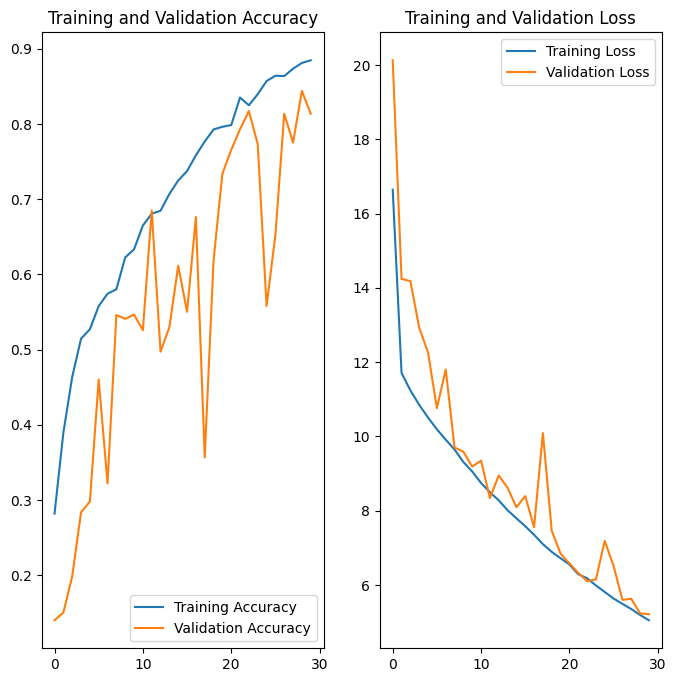

In [83]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

**Yes the class rebalacing helped. Now both the training and validation accuracy has very high when compared to previous iterations**

**There is no underfitting or overfitting problem**

**Latest value: accuracy: 0.8688 - loss: 5.1101 - val_accuracy: 0.8138 - val_loss: 5.2126**

